In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!python -V

Python 3.10.12


In [ ]:
!pip install mxnet
!pip install gluonnlp==0.8.0
!pip install pandas tqdm
!pip install sentencepiece
!pip install transformers
!pip install torch -U

In [ ]:
!nvcc -V

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2022 NVIDIA Corporation
Built on Wed_Sep_21_10:33:58_PDT_2022
Cuda compilation tools, release 11.8, V11.8.89
Build cuda_11.8.r11.8/compiler.31833905_0


In [ ]:
!pip install 'git+https://github.com/SKTBrain/KoBERT.git#egg=kobert_tokenizer&subdirectory=kobert_hf'

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/SKTBrain/KoBERT.git to /tmp/pip-install-rld0f5gp/kobert-tokenizer_e6501487731c4acc82d782a5aa7b2099
  Running command git clone --filter=blob:none --quiet https://github.com/SKTBrain/KoBERT.git /tmp/pip-install-rld0f5gp/kobert-tokenizer_e6501487731c4acc82d782a5aa7b2099
  Resolved https://github.com/SKTBrain/KoBERT.git to commit 47a69af87928fc24e20f571fe10c3cc9dd9af9a3
  Preparing metadata (setup.py) ... done
  Created wheel for kobert_tokenizer: filename=kobert_tokenizer-0.1-py3-none-any.whl size=4632 sha256=02936d011aa77358a7a044227a103850d7cc28e10ef317de10939d3000df48f9
  Stored in directory: /tmp/pip-ephem-wheel-cache-nwnmkno6/wheels/e9/1a/3f/a864970e8a169c176befa3c4a1e07aa612f69195907a4045fe
Successfully built kobert_tokenizer


In [ ]:
import torch
from torch import nn
import torch.nn.functional as F
from torch.optim import AdamW
from torch.utils.data import Dataset, DataLoader
import gluonnlp as nlp
import numpy as np
from tqdm import tqdm, tqdm_notebook

/usr/local/lib/python3.10/dist-packages/mxnet/optimizer/optimizer.py:163: UserWarning: WARNING: New optimizer gluonnlp.optimizer.lamb.LAMB is overriding existing optimizer mxnet.optimizer.optimizer.LAMB
  warnings.warn('WARNING: New optimizer %s.%s is overriding '


In [ ]:
from kobert_tokenizer import KoBERTTokenizer
from transformers import BertModel
from transformers.optimization import get_cosine_schedule_with_warmup

In [ ]:
# GPU 사용
device = torch.device("cuda:0")

In [ ]:
tokenizer = KoBERTTokenizer.from_pretrained('skt/kobert-base-v1')
bertmodel = BertModel.from_pretrained('skt/kobert-base-v1', return_dict=False)
vocab = nlp.vocab.BERTVocab.from_sentencepiece(tokenizer.vocab_file, padding_token='[PAD]')

## 사용자 정의 토큰 추가
new_tokens = ['우울', '슬픔', '외로움', '분노', '무기력', '의욕상실', '식욕저하', '식욕증가', '감정조절이상',
              '불면', '초조', '피로', '죄책감', '집중력저하', '자신감 저하', '자존감저하', '절망', '자살', '불안']
tokenizer.add_tokens(new_tokens)
# 사용자 토큰 추가했던 것 bertmodel 의 embedding_layer에도 추가해줘야함
bertmodel.resize_token_embeddings(len(tokenizer))

The tokenizer class you load from this checkpoint is not the same type as the class this function is called from. It may result in unexpected tokenization. 
The tokenizer class you load from this checkpoint is 'XLNetTokenizer'. 
The class this function is called from is 'KoBERTTokenizer'.


Embedding(8021, 768)

In [ ]:
import pandas as pd
data = pd.read_csv('/content/drive/MyDrive/KOBERT/data/intent_dataset_method2_0608.csv', encoding='utf-8')

df = pd.DataFrame()

df['발화문'] = pd.DataFrame(data['document'])
df['상황'] = pd.DataFrame(data['intent'])

df.loc[(df['상황'] == "감정조절이상"), '상황'] = 0  
df.loc[(df['상황'] == "불면"), '상황'] = 1  
df.loc[(df['상황'] == "분노"), '상황'] = 2  
df.loc[(df['상황'] == "불안"), '상황'] = 3  
df.loc[(df['상황'] == "초조"), '상황'] = 4  
df.loc[(df['상황'] == "슬픔"), '상황'] = 5  
df.loc[(df['상황'] == "외로움"), '상황'] = 6  
df.loc[(df['상황'] == "우울"), '상황'] = 7  
df.loc[(df['상황'] == "의욕상실"), '상황'] = 8  
df.loc[(df['상황'] == "무기력"), '상황'] = 9  
df.loc[(df['상황'] == "자살"), '상황'] = 10  
df.loc[(df['상황'] == "자존감저하"), '상황'] = 11 
df.loc[(df['상황'] == "절망"), '상황'] = 12  
df.loc[(df['상황'] == "죄책감"), '상황'] = 13  
df.loc[(df['상황'] == "집중력저하"), '상황'] = 14
df.loc[(df['상황'] == "피로"), '상황'] = 15 
df.loc[(df['상황'] == "식욕저하"), '상황'] = 16
df.loc[(df['상황'] == "식욕증가"), '상황'] = 17
df.loc[(df['상황'] == "일상"), '상황'] = 18

import re

data_list = []
for q, label in zip(df['발화문'], df['상황'])  :
    data = []
    data.append(re.sub('[^ㄱ-ㅎㅏ-ㅣ가-힣\s\.]', '', q))
    data.append(str(label))
    data_list.append(data)

In [ ]:
data_list[:15]

[['제 감정이 이상해진 것 같아요. 남편만 보면 화가 치밀어 오르고 감정 조절이 안되요.', '0'],
 ['더 이상 내 감정을 내가 컨트롤 못 하겠어.', '0'],
 ['하루종일 오르락내리락 롤러코스터 타는 기분이에요.', '0'],
 ['꼭 롤러코스터 타는 것 같아요.', '0'],
 ['롤러코스터 타는 것처럼 기분이 왔다 갔다 해요.', '0'],
 ['작년 가을부터 감정조절이 잘 안 되는 거 같아.', '0'],
 ['예전에 비해서 인내심이 너무 짧아진 거 같아.', '0'],
 ['더 이상 혼자서는 감정조절을 못하겠어.', '0'],
 ['점점 나 자신을 컨트롤하지 못하는 기분이야.', '0'],
 ['나도 이러기 싫은데 내 마음대로 안돼.', '0'],
 ['맨정신일 때는 저를 주체할 수 가 없었거든요.', '0'],
 ['주체가 안 돼.', '0'],
 ['이렇게 쌓이고 쌓이다 나중에 확 터지거든요. 진짜 걷잡을 수 없이요.', '0'],
 ['근데 감정을 다스리지 못해 욱하기도하고.', '0'],
 ['순간순간 감정조절을 못해요.', '0']]

In [ ]:
emotion_dict = {0: '감정조절이상', 1: '불면', 2: '분노', 3: '불안', 4: '초조', 5: '슬픔', 6: '외로움', 7: '우울', 8: '의욕상실', 9: '무기력',
                10: '자살', 11: '자존감저하', 12: '절망', 13: '죄책감', 14: '집중력저하', 15: '피로', 16: '식욕저하', 17: '식욕증가', 18: '일상'}

In [ ]:
from sklearn.model_selection import train_test_split
                                                         
dataset_train, dataset_test = train_test_split(data_list, test_size=0.1, random_state=42)

In [ ]:
print(len(dataset_train), '', len(dataset_test))

8618  958


In [ ]:
dataset_train[100:120]

[['당연히 뛰는 동안 너무 힘들었어. 하지만 모든 게 다 보상이 되더라.', '18'],
 ['뛰는 동안 너무 힘들었지만 결승선을 통과하니까 그렇게 뿌듯하더라고.', '18'],
 ['그래볼까 그러면 기분이 좀 나아질까', '18'],
 ['눈초리 받는 것 같아', '11'],
 ['그럼. 완전히 끝났지. 한달간 고생 많았어.', '18'],
 ['압박 심해', '3'],
 ['분노심이 생겨.', '2'],
 ['몽롱해.', '7'],
 ['소화불량이야', '16'],
 ['친구들이랑 인제 여행도 가고 휴식도 좀 취할려고요.', '18'],
 ['당연히 같이 운동하는 사람들이 있어 이번에 대회도 같이 참가했어.', '18'],
 ['같이 뛰기도 하고 혼자 뛰기도 해.', '18'],
 ['그리고 한 가지 일에 집중을 못 해. 되게 혼자 엄청 분주해져.', '14'],
 ['누가 저를 해칠 것 같아요', '11'],
 ['인생이 즐겁지가 않아.', '9'],
 ['난 선수가 아니라 일반인에서 좋은 기록을 세웠다고.', '18'],
 ['그래. 알겠어. 얼마나 이쁘고 향이 좋은지 보여줄게.', '18'],
 ['부르르 떨리는 거야', '4'],
 ['내가 지금 안 쓰겠다 했는데 왜 이렇게 시비 걸어.', '18'],
 ['관둘 거예요', '12']]

In [ ]:
class BERTSentenceTransform:
    
    def __init__(self, tokenizer, max_seq_length, vocab, pad=True, pair=True):
        self._tokenizer = tokenizer
        self._max_seq_length = max_seq_length
        self._pad = pad
        self._pair = pair
        self._vocab = vocab ##추가

    def __call__(self, line): 
        

        # 유니코드로 변환
        text_a = line[0]
        if self._pair:
            assert len(line) == 2  # 2개로 이뤄진문장 있을 수 있음
            text_b = line[1]

        #tokens_a = self._tokenizer(text_a)   
        tokens_a = self._tokenizer.tokenize(text_a) 
        tokens_b = None

        if self._pair:
            tokens_b = self._tokenizer(text_b)

        if tokens_b:
            # `tokens_a` 와 `tokens_b` max_seq_length-3을 넘지 않도록 수정
            # [CLS], [SEP], [SEP]를 포함하므로 "- 3" 들어가야함
            self._truncate_seq_pair(tokens_a, tokens_b,
                                    self._max_seq_length - 3)
        else:
            # 문장 한 개일 경우 [CLS], [SEP] 두 개이므로 "- 2"
            if len(tokens_a) > self._max_seq_length - 2:
                tokens_a = tokens_a[0:(self._max_seq_length - 2)]

        
        #vocab = self._tokenizer.vocab
        vocab = self._vocab
        tokens = []
        tokens.append(vocab.cls_token)
        tokens.extend(tokens_a)
        tokens.append(vocab.sep_token)
        segment_ids = [0] * len(tokens)

        if tokens_b:
            tokens.extend(tokens_b)
            tokens.append(vocab.sep_token)
            segment_ids.extend([1] * (len(tokens) - len(segment_ids)))

        input_ids = self._tokenizer.convert_tokens_to_ids(tokens)

        #input_ids = tokens_a['input_ids']

        # 문장의 유효길이 valid_length는 input_ids의 길이. 그 이외는 0 패딩
        valid_length = len(input_ids)

        if self._pad:
            # 시퀀스 길이만큼 0 패딩
            padding_length = self._max_seq_length - valid_length
            input_ids.extend([vocab[vocab.padding_token]] * padding_length)
            segment_ids.extend([0] * padding_length)

        return np.array(input_ids, dtype='int32'), np.array(valid_length, dtype='int32'),\
            np.array(segment_ids, dtype='int32')



In [ ]:
# 파라미터
max_len = 64
batch_size = 16
warmup_ratio = 0.1
num_epochs = 5
max_grad_norm = 1
log_interval = 200
learning_rate =  5e-5

In [ ]:
#데이터셋 input_ids, valid_length, segment_ids 로
class BERTDataset(Dataset):
    def __init__(self, dataset, sent_idx, label_idx, bert_tokenizer, vocab, max_len, pad, pair):
        transform = BERTSentenceTransform(bert_tokenizer, max_seq_length=max_len, vocab=vocab, pad=pad, pair=pair)
        self.sentences = [transform([i[sent_idx]]) for i in dataset]
        self.labels = [np.int32(i[label_idx]) for i in dataset]

    def __getitem__(self, i):
        return (self.sentences[i] + (self.labels[i], ))

    def __len__(self):
        return (len(self.labels))

In [ ]:
data_train = BERTDataset(dataset_train, 0, 1, tokenizer, vocab, max_len, True, False)
data_test = BERTDataset(dataset_test, 0, 1, tokenizer, vocab, max_len, True, False)

In [ ]:
data_train[0][0]

array([   2, 4902, 4924, 5757, 6004, 4955, 5793, 1754, 4627, 6116, 2086,
       1931, 5671, 6887, 4627, 6116, 3697, 1307, 6896, 1933, 6394, 5405,
       6855,   54, 1458, 3010, 5655,    3,    1,    1,    1,    1,    1,
          1,    1,    1,    1,    1,    1,    1,    1,    1,    1,    1,
          1,    1,    1,    1,    1,    1,    1,    1,    1,    1,    1,
          1,    1,    1,    1,    1,    1,    1,    1,    1], dtype=int32)

In [ ]:
## token_ids 타입 
type(data_train[0][0])

numpy.ndarray

In [ ]:
"""## 변환한 token_id들 중 kobert의 vocab_size의 index를 넘어가는 값이 존재하는지 확인
## vocab에 존재하지 않는 단어가 있으면 학습 불가능 -> 처리해야함

vocab_size = bertmodel.config.vocab_size
print(vocab_size)

wrong_index = []
wrong_word = []

for i in range(len(data_train)):
  # 토큰id로 변환된 문장들이 담긴 리스트
  token_id_list = data_train[i][0]
  max_token_id = token_id_list.max()
  max_token_id_index = np.argmax(token_id_list)
  
  # 토큰 id가 vocab_size보다 크면 wrong_index에 dataset index, 해당 id값과 앞뒤 id값 추가 
  if max_token_id >= vocab_size:
    wrong_index.append(i)
    wrong_word.append([token_id_list[max_token_id_index - 1],max_token_id,token_id_list[max_token_id_index + 1]])

print(len(wrong_index))
print(wrong_index)
print(wrong_word)

##토큰id를 토큰으로 다시 변환해서 확인해보고 전처리하기
for w in wrong_word:
  print(tokenizer.convert_ids_to_tokens(w))
  
"""

'## 변환한 token_id들 중 kobert의 vocab_size의 index를 넘어가는 값이 존재하는지 확인\n## vocab에 존재하지 않는 단어가 있으면 학습 불가능 -> 처리해야함\n\nvocab_size = bertmodel.config.vocab_size\nprint(vocab_size)\n\nwrong_index = []\nwrong_word = []\n\nfor i in range(len(data_train)):\n  # 토큰id로 변환된 문장들이 담긴 리스트\n  token_id_list = data_train[i][0]\n  max_token_id = token_id_list.max()\n  max_token_id_index = np.argmax(token_id_list)\n  \n  # 토큰 id가 vocab_size보다 크면 wrong_index에 dataset index, 해당 id값과 앞뒤 id값 추가 \n  if max_token_id >= vocab_size:\n    wrong_index.append(i)\n    wrong_word.append([token_id_list[max_token_id_index - 1],max_token_id,token_id_list[max_token_id_index + 1]])\n\nprint(len(wrong_index))\nprint(wrong_index)\nprint(wrong_word)\n\n##토큰id를 토큰으로 다시 변환해서 확인해보고 전처리하기\nfor w in wrong_word:\n  print(tokenizer.convert_ids_to_tokens(w))\n  \n'

# 모델훈련

In [ ]:
train_dataloader = torch.utils.data.DataLoader(data_train, batch_size=batch_size, num_workers=2)
test_dataloader = torch.utils.data.DataLoader(data_test, batch_size=batch_size, num_workers=2)

In [ ]:
class BERTClassifier(nn.Module):
    def __init__(self,
                 bert,
                 hidden_size = 768,
                 num_classes=19,
                 dr_rate=None,
                 params=None):
        super(BERTClassifier, self).__init__()
        self.bert = bert
        self.dr_rate = dr_rate
                 
        self.classifier = nn.Linear(hidden_size , num_classes)
        if dr_rate:
            self.dropout = nn.Dropout(p=dr_rate)
    
    def gen_attention_mask(self, token_ids, valid_length):
        attention_mask = torch.zeros_like(token_ids)
        for i, v in enumerate(valid_length):
            attention_mask[i][:v] = 1
        return attention_mask.float()

    def forward(self, token_ids, valid_length, segment_ids):
        attention_mask = self.gen_attention_mask(token_ids, valid_length)
        
        _, pooler = self.bert(input_ids = token_ids, token_type_ids = segment_ids.long(), attention_mask = attention_mask.float().to(token_ids.device))
        if self.dr_rate:
            out = self.dropout(pooler)
        return self.classifier(out)

In [ ]:
model = BERTClassifier(bertmodel,  dr_rate=0.5).to(device)

# Prepare optimizer and schedule (linear warmup and decay)
no_decay = ['bias', 'LayerNorm.weight']

optimizer_grouped_parameters = [
    {'params': [p for n, p in model.named_parameters() if not any(nd in n for nd in no_decay)], 'weight_decay': 0.01},
    {'params': [p for n, p in model.named_parameters() if any(nd in n for nd in no_decay)], 'weight_decay': 0.0}
]

# 옵티마이저 설정
optimizer = AdamW(optimizer_grouped_parameters, lr=learning_rate)

# 손실 함수 설정
loss_fn = nn.CrossEntropyLoss()

# 전체 훈련 스텝 수 설정
t_total = len(train_dataloader) * num_epochs

# 웜업 스텝 설정
warmup_step = int(t_total * warmup_ratio)

# 스케줄러 설정
scheduler = get_cosine_schedule_with_warmup(optimizer, num_warmup_steps=warmup_step, num_training_steps=t_total)

def calc_accuracy(X, Y):
    max_vals, max_indices = torch.max(X, 1)
    train_acc = (max_indices == Y).sum().item() / max_indices.size()[0]
    return train_acc


In [ ]:
if torch.cuda.is_available():    
    device = torch.device("cuda")
    print('There are %d GPU(s) available.' % torch.cuda.device_count())
    print('We will use the GPU:', torch.cuda.get_device_name(0))
else:
    device = torch.device("cpu")
    print('No GPU available, using the CPU instead.')

There are 1 GPU(s) available.
We will use the GPU: Tesla T4


In [ ]:
train_acc_list = []
train_loss_list = []
test_acc_list = []
test_loss_list = []

for e in range(num_epochs):
    print("\n======================================== epoch {} ========================================\n".format(e+1))

    train_acc = 0.0
    test_acc = 0.0
    train_loss = 0.0
    test_loss = 0.0
    total_tokens = 0  # 배치에 포함된 총 토큰 개수

    model.train()
    for batch_id, (token_ids, valid_length, segment_ids, label) in enumerate(tqdm(train_dataloader)):
        optimizer.zero_grad()

        token_ids = token_ids.long().to(device)
        segment_ids = segment_ids.long().to(device)
        valid_length = valid_length.to(device)
        label = label.long().to(device)

        out = model(token_ids, valid_length, segment_ids)

        loss = loss_fn(out, label)
        loss.backward()

        torch.nn.utils.clip_grad_norm_(model.parameters(), max_grad_norm)
        optimizer.step()
        scheduler.step()  # Update learning rate schedule

        train_acc += calc_accuracy(out, label)
        train_loss += loss.item() * len(token_ids)  # 배치의 토큰 개수를 곱하여 정규화
        total_tokens += len(token_ids)

        if batch_id % log_interval == 0:
            print("batch_id {} train_acc: {} loss: {}".format(batch_id+1, train_acc / (batch_id+1), loss.item()))
    
    # 모델 테스트
    model.eval()
    print("")
    for batch_id, (token_ids, valid_length, segment_ids, label) in enumerate(tqdm(test_dataloader)):
        token_ids = token_ids.long().to(device)
        segment_ids = segment_ids.long().to(device)
        valid_length = valid_length.to(device)
        label = label.long().to(device)

        out = model(token_ids, valid_length, segment_ids)

        loss = loss_fn(out, label)

        test_acc += calc_accuracy(out, label)
        test_loss += loss.item() * len(token_ids)  # 배치의 토큰 개수를 곱하여 정규화
        total_tokens += len(token_ids)

    avg_train_acc = train_acc / len(train_dataloader)
    avg_test_acc = test_acc / len(test_dataloader)
    avg_train_loss = train_loss / total_tokens  # 총 토큰 개수로 정규화
    avg_test_loss = test_loss / total_tokens  # 총 토큰 개수로 정규화

    train_acc_list.append(avg_train_acc)
    train_loss_list.append(avg_train_loss)
    test_acc_list.append(avg_test_acc)
    test_loss_list.append(avg_test_loss)

    print("")
    print("train_acc: {}, train_loss: {}".format(avg_train_acc, avg_train_loss))
    print("test_acc: {}, test_loss: {}".format(avg_test_acc, avg_test_loss))


======================================== epoch 1 ========================================



  0%|          | 2/539 [00:00<02:30,  3.57it/s]

batch_id 1 train_acc: 0.9375 loss: 0.09768008440732956


 37%|███▋      | 202/539 [00:37<01:03,  5.35it/s]

batch_id 201 train_acc: 0.9785447761194029 loss: 0.031035251915454865


 74%|███████▍  | 401/539 [01:15<00:27,  5.00it/s]

batch_id 401 train_acc: 0.9778678304239401 loss: 0.10283002257347107


100%|██████████| 539/539 [01:43<00:00,  5.19it/s]


100%|██████████| 60/60 [00:03<00:00, 15.44it/s]



train_acc: 0.9726345083487941, train_loss: 0.11900042243434233
test_acc: 0.934375, test_loss: 0.04257653491462036

======================================== epoch 2 ========================================



  0%|          | 1/539 [00:00<03:05,  2.91it/s]

batch_id 1 train_acc: 1.0 loss: 0.012071116827428341


 37%|███▋      | 201/539 [00:41<01:07,  4.98it/s]

batch_id 201 train_acc: 0.9760572139303483 loss: 0.22883792221546173


 75%|███████▍  | 402/539 [01:22<00:27,  4.94it/s]

batch_id 401 train_acc: 0.9758416458852868 loss: 0.39694684743881226


100%|██████████| 539/539 [01:50<00:00,  4.89it/s]


100%|██████████| 60/60 [00:03<00:00, 15.99it/s]



train_acc: 0.974373840445269, train_loss: 0.11412448097026612
test_acc: 0.9260416666666667, test_loss: 0.044383879530682395

======================================== epoch 3 ========================================



  0%|          | 1/539 [00:00<02:28,  3.63it/s]

batch_id 1 train_acc: 1.0 loss: 0.008315101265907288


 37%|███▋      | 201/539 [00:41<01:09,  4.84it/s]

batch_id 201 train_acc: 0.9729477611940298 loss: 0.4134730100631714


 74%|███████▍  | 401/539 [01:21<00:27,  4.95it/s]

batch_id 401 train_acc: 0.9731920199501247 loss: 0.008413916453719139


100%|██████████| 539/539 [01:50<00:00,  4.90it/s]


100%|██████████| 60/60 [00:03<00:00, 16.00it/s]



train_acc: 0.9714749536178108, train_loss: 0.13387227964402917
test_acc: 0.9206845238095238, test_loss: 0.04323990839053453

======================================== epoch 4 ========================================



  0%|          | 1/539 [00:00<02:25,  3.70it/s]

batch_id 1 train_acc: 1.0 loss: 0.015023128129541874


 37%|███▋      | 201/539 [00:41<01:08,  4.91it/s]

batch_id 201 train_acc: 0.9769900497512438 loss: 0.1857803463935852


 74%|███████▍  | 401/539 [01:21<00:28,  4.82it/s]

batch_id 401 train_acc: 0.9774002493765586 loss: 0.004116837866604328


100%|██████████| 539/539 [01:50<00:00,  4.89it/s]


100%|██████████| 60/60 [00:03<00:00, 15.66it/s]



train_acc: 0.976113172541744, train_loss: 0.11588152435617156
test_acc: 0.9291666666666667, test_loss: 0.047248051310410925

======================================== epoch 5 ========================================



  0%|          | 2/539 [00:00<02:07,  4.21it/s]

batch_id 1 train_acc: 1.0 loss: 0.057574789971113205


 37%|███▋      | 201/539 [00:41<01:10,  4.83it/s]

batch_id 201 train_acc: 0.9788557213930348 loss: 0.00753356609493494


 74%|███████▍  | 401/539 [01:22<00:27,  4.93it/s]

batch_id 401 train_acc: 0.9767768079800498 loss: 0.4163161814212799


100%|██████████| 539/539 [01:50<00:00,  4.88it/s]


100%|██████████| 60/60 [00:03<00:00, 15.93it/s]


train_acc: 0.9769248608534323, train_loss: 0.1103948182236744
test_acc: 0.925, test_loss: 0.04799961225840021


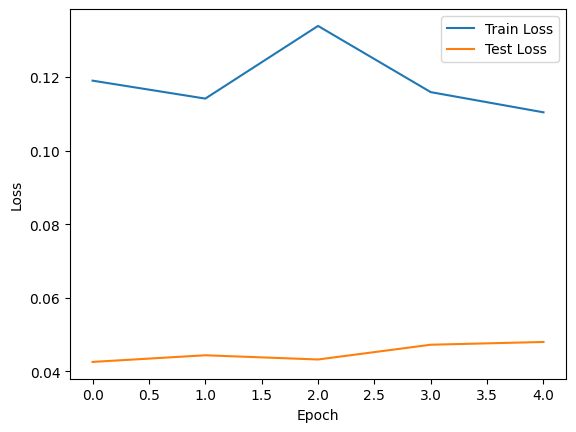

[0.11900042243434233, 0.11412448097026612, 0.13387227964402917, 0.11588152435617156, 0.1103948182236744]
[0.04257653491462036, 0.044383879530682395, 0.04323990839053453, 0.047248051310410925, 0.04799961225840021]


In [ ]:
import matplotlib.pyplot as plt

# 훈련 데이터와 테스트 데이터의 손실 변화를 그래프로 그리기
plt.plot(train_loss_list, label='Train Loss')
plt.plot(test_loss_list, label='Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

print(train_loss_list)
print(test_loss_list)

In [ ]:
torch.save(model, '/content/drive/MyDrive/KOBERT/model/kobert_text_depress_model_test2.pt')

In [ ]:
model = torch.load("/content/drive/MyDrive/KOBERT/model/kobert_text_depress_model_test2.pt", map_location=device)
print(model)

BERTClassifier(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(8021, 768)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
     